In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

import os
from PIL import Image
from tqdm import tqdm
import glob

In [2]:
# V3 : Residual Block과 BatchNorm을 적용한 개선 모델
import torch
import torch.nn as nn
import torch.nn.functional as F

# 재사용을 위한 잔차 블록 정의
class ResidualBlock(nn.Module):
    def __init__(self, channels):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(channels, channels, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(channels)
        self.conv2 = nn.Conv2d(channels, channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(channels)

    def forward(self, x):
        residual = x
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out = out + residual # 핵심: Shortcut Connection
        return F.relu(out)

class AODnet_MultiBranch_V3(nn.Module):
    def __init__(self):
        super(AODnet_MultiBranch_V3, self).__init__()
        print("[Model] V3 Multi-Branch AODNet (Residual) 초기화 중...")

        # 공통 특징 추출 레이어 (옵션)
        self.initial_conv = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.initial_bn = nn.BatchNorm2d(16)

        # ----- 각 브랜치의 채널 수를 늘리고 잔차 블록을 사용 -----
        # K1 Branch (작은 스케일)
        self.k1_conv = nn.Conv2d(16, 16, kernel_size=3, padding=1)
        self.k1_resblock = ResidualBlock(16)

        # K2 Branch (중간 스케일)
        self.k2_conv = nn.Conv2d(16, 16, kernel_size=5, padding=2)
        self.k2_resblock = ResidualBlock(16)
        
        # K3 Branch (큰 스케일)
        self.k3_conv = nn.Conv2d(16, 16, kernel_size=7, padding=3)
        self.k3_resblock = ResidualBlock(16)

        # ----- 융합(Fusion) 레이어 -----
        # 3개 브랜치(각 16채널) 결과를 합치므로 입력은 16*3=48 채널
        self.fusion_conv1 = nn.Conv2d(48, 16, kernel_size=3, padding=1)
        self.fusion_resblock = ResidualBlock(16)
        self.fusion_conv2 = nn.Conv2d(16, 3, kernel_size=1) # 최종 K를 위한 1x1 conv

        self.b = nn.Parameter(torch.tensor([1.0])) # 학습 가능한 파라미터

        print("[Model] V3 Multi-Branch AODNet 초기화 완료\n")

    def forward(self, x):
        # 초기 특징 추출
        x_initial = F.relu(self.initial_bn(self.initial_conv(x)))

        # 각 브랜치 연산
        k1 = self.k1_resblock(F.relu(self.k1_conv(x_initial)))
        k2 = self.k2_resblock(F.relu(self.k2_conv(x_initial)))
        k3 = self.k3_resblock(F.relu(self.k3_conv(x_initial)))

        # Fusion 단계
        k_fused = torch.cat((k1, k2, k3), dim=1)
        k_fused = self.fusion_resblock(F.relu(self.fusion_conv1(k_fused)))
        k_final = self.fusion_conv2(k_fused) # 최종 K에는 ReLU를 적용하지 않는 편이 나을 수 있음

        # AOD-Net 복원 공식
        # k_final이 너무 큰 값이나 작은 값을 갖지 않도록 clamp를 걸어줄 수도 있음
        k_final = torch.clamp(k_final, 0, 1) 
        output = k_final * x - k_final + self.b
        
        return torch.clamp(output, 0, 1) # 최종 결과물도 0~1 사이로 맞춰줌

In [3]:
def print_model_summary(model, model_name):
    """모델의 파라미터 정보와 총 개수를 출력하는 함수"""
    print(f"========== {model_name} Summary ==========")
    
    # 모델의 각 파라미터 이름과 크기(shape) 출력
    for name, param in model.named_parameters():
        if param.requires_grad:
            print(f"Layer: {name},  Shape: {param.shape}")
    
    # 전체 파라미터 개수 계산 및 출력
    total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"\nTotal trainable parameters: {total_params:,}")
    print("=" * (len(model_name) + 24))
    print("\n")


# 1. AODnet 모델 객체 생성 및 파라미터 확인
model = AODnet_MultiBranch_V3()
print_model_summary(model, "AODnet")

[Model] V3 Multi-Branch AODNet (Residual) 초기화 중...
[Model] V3 Multi-Branch AODNet 초기화 완료

========== AODnet Summary ==========
Layer: b,  Shape: torch.Size([1])
Layer: initial_conv.weight,  Shape: torch.Size([16, 3, 3, 3])
Layer: initial_conv.bias,  Shape: torch.Size([16])
Layer: initial_bn.weight,  Shape: torch.Size([16])
Layer: initial_bn.bias,  Shape: torch.Size([16])
Layer: k1_conv.weight,  Shape: torch.Size([16, 16, 3, 3])
Layer: k1_conv.bias,  Shape: torch.Size([16])
Layer: k1_resblock.conv1.weight,  Shape: torch.Size([16, 16, 3, 3])
Layer: k1_resblock.conv1.bias,  Shape: torch.Size([16])
Layer: k1_resblock.bn1.weight,  Shape: torch.Size([16])
Layer: k1_resblock.bn1.bias,  Shape: torch.Size([16])
Layer: k1_resblock.conv2.weight,  Shape: torch.Size([16, 16, 3, 3])
Layer: k1_resblock.conv2.bias,  Shape: torch.Size([16])
Layer: k1_resblock.bn2.weight,  Shape: torch.Size([16])
Layer: k1_resblock.bn2.bias,  Shape: torch.Size([16])
Layer: k2_conv.weight,  Shape: torch.Size([16, 16, 5, 

In [4]:
class DehazeDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        """
        :param data_dir: train, test, val 폴더 중 하나의 경로 (예: 'dataset2_split/train')
        :param transform: 이미지에 적용할 torchvision.transforms
        """
        self.gt_dir = os.path.join(data_dir, 'gt')
        self.input_dir = os.path.join(data_dir, 'input')
        self.transform = transform
        
        # input 폴더의 파일 목록을 기준으로 삼음
        self.image_files = os.listdir(self.input_dir)

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        filename = self.image_files[idx]
        
        input_path = os.path.join(self.input_dir, filename)
        gt_path = os.path.join(self.gt_dir, filename)
        
        # PIL 라이브러리를 사용해 이미지 열기 (RGB 형식으로 변환)
        input_image = Image.open(input_path).convert('RGB')
        gt_image = Image.open(gt_path).convert('RGB')
        
        if self.transform:
            input_image = self.transform(input_image)
            gt_image = self.transform(gt_image)
            
        return input_image, gt_image

In [5]:
# GPU 사용 설정
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {DEVICE}")

# 하이퍼파라미터
LEARNING_RATE = 0.0001
BATCH_SIZE = 16
NUM_EPOCHS = 100

# 데이터셋 경로 (split_dataset.py 실행 후 생성된 폴더)
DATA_DIR = "./dataset_split"
TRAIN_DIR = os.path.join(DATA_DIR, 'train')
VAL_DIR = os.path.join(DATA_DIR, 'val')

# 학습된 모델 가중치를 저장할 경로
MODEL_SAVE_PATH = "./pt/TBaodNetV3"
os.makedirs(MODEL_SAVE_PATH, exist_ok=True)

Using device: cuda


In [6]:
# 이미지 변환 설정
transform = transforms.Compose([
    transforms.Resize((360, 240)), # 이미지 크기를 256x256으로 조절 H, W 순서
    transforms.ToTensor()          # 이미지를 PyTorch 텐서로 변환 (0~1 값으로 정규화)
])

# 훈련 데이터셋 및 데이터 로더
train_dataset = DehazeDataset(data_dir=TRAIN_DIR, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)

# 검증 데이터셋 및 데이터 로더
val_dataset = DehazeDataset(data_dir=VAL_DIR, transform=transform)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

print(f"훈련 데이터셋 크기: {len(train_dataset)}개")
print(f"검증 데이터셋 크기: {len(val_dataset)}개")

# 셀 5 실행 후 이 코드를 실행해보세요
try:
    input_img, gt_img = train_dataset[0]
    print("데이터셋 로딩 성공!")
    print("Input 이미지 텐서 모양:", input_img.shape)
    print("GT 이미지 텐서 모양:", gt_img.shape)
except Exception as e:
    print("데이터셋 로딩 중 오류 발생:", e)

훈련 데이터셋 크기: 3543개
검증 데이터셋 크기: 507개
데이터셋 로딩 성공!
Input 이미지 텐서 모양: torch.Size([3, 360, 240])
GT 이미지 텐서 모양: torch.Size([3, 360, 240])


In [7]:
# 모델 인스턴스 생성 및 GPU로 이동
# model = AODnet().to(DEVICE) # 기본 모델을 사용하려면 이 줄의 주석을 해제
model = AODnet_MultiBranch_V3().to(DEVICE) # PONO 모델 사용
print("Model:", model.__class__.__name__)

# 손실 함수 (Loss Function) - 이미지 복원에는 MSE Loss가 일반적으로 사용됨
criterion = nn.MSELoss()

# 옵티마이저 (Optimizer) - Adam이 안정적이고 좋은 성능을 보임
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

[Model] V3 Multi-Branch AODNet (Residual) 초기화 중...
[Model] V3 Multi-Branch AODNet 초기화 완료

Model: AODnet_MultiBranch_V3


In [8]:
# 각 에폭의 손실 값을 저장할 리스트 생성
train_loss_history = [] # <<< 추가
val_loss_history = []   # <<< 추가

best_val_loss = float('inf')

print("\n===== 모델 학습을 시작합니다 =====")
for epoch in range(NUM_EPOCHS):
    # --- 훈련 단계 ---
    model.train()
    train_loss = 0.0
    
    train_iterator = tqdm(train_loader, desc=f"Epoch {epoch+1}/{NUM_EPOCHS} [Train]")
    for hazy_images, clean_images in train_iterator:
        hazy_images = hazy_images.to(DEVICE)
        clean_images = clean_images.to(DEVICE)
        
        outputs = model(hazy_images)
        loss = criterion(outputs, clean_images)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        train_iterator.set_postfix({'loss': loss.item()})
        
    avg_train_loss = train_loss / len(train_loader)
    train_loss_history.append(avg_train_loss) # <<< 추가

    # --- 검증 단계 ---
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        val_iterator = tqdm(val_loader, desc=f"Epoch {epoch+1}/{NUM_EPOCHS} [Val]")
        for hazy_images, clean_images in val_iterator:
            hazy_images = hazy_images.to(DEVICE)
            clean_images = clean_images.to(DEVICE)
            
            outputs = model(hazy_images)
            loss = criterion(outputs, clean_images)
            val_loss += loss.item()
            val_iterator.set_postfix({'loss': loss.item()})
            
    avg_val_loss = val_loss / len(val_loader)
    val_loss_history.append(avg_val_loss) # <<< 추가
    
    print(f"Epoch [{epoch+1}/{NUM_EPOCHS}], Train Loss: {avg_train_loss:.6f}, Val Loss: {avg_val_loss:.6f}")
    
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        save_file = os.path.join(MODEL_SAVE_PATH, f"best_model_epoch_{epoch+1}.pth")
        torch.save(model.state_dict(), save_file)
        print(f"***** Best model saved to {save_file} (Val Loss: {best_val_loss:.6f}) *****\n")

print("\n===== 모든 학습이 완료되었습니다! =====")


===== 모델 학습을 시작합니다 =====


Epoch 1/100 [Train]:   0%|          | 0/222 [00:00<?, ?it/s]

Epoch 1/100 [Val]: 100%|██████████| 32/32 [00:06<00:00,  5.26it/s, loss=0.00814]


Epoch [1/100], Train Loss: 0.054839, Val Loss: 0.031847
***** Best model saved to ./pt/TBaodNetV3\best_model_epoch_1.pth (Val Loss: 0.031847) *****



Epoch 2/100 [Val]: 100%|██████████| 32/32 [00:05<00:00,  5.74it/s, loss=0.00702]


Epoch [2/100], Train Loss: 0.031414, Val Loss: 0.029294
***** Best model saved to ./pt/TBaodNetV3\best_model_epoch_2.pth (Val Loss: 0.029294) *****



Epoch 3/100 [Val]: 100%|██████████| 32/32 [00:05<00:00,  6.21it/s, loss=0.00643]


Epoch [3/100], Train Loss: 0.028891, Val Loss: 0.027210
***** Best model saved to ./pt/TBaodNetV3\best_model_epoch_3.pth (Val Loss: 0.027210) *****



Epoch 4/100 [Val]: 100%|██████████| 32/32 [00:05<00:00,  6.21it/s, loss=0.00617]


Epoch [4/100], Train Loss: 0.027013, Val Loss: 0.025626
***** Best model saved to ./pt/TBaodNetV3\best_model_epoch_4.pth (Val Loss: 0.025626) *****



Epoch 5/100 [Val]: 100%|██████████| 32/32 [00:05<00:00,  6.25it/s, loss=0.00626]


Epoch [5/100], Train Loss: 0.025623, Val Loss: 0.024499
***** Best model saved to ./pt/TBaodNetV3\best_model_epoch_5.pth (Val Loss: 0.024499) *****



Epoch 6/100 [Val]: 100%|██████████| 32/32 [00:05<00:00,  6.27it/s, loss=0.00653]


Epoch [6/100], Train Loss: 0.024634, Val Loss: 0.023748
***** Best model saved to ./pt/TBaodNetV3\best_model_epoch_6.pth (Val Loss: 0.023748) *****



Epoch 7/100 [Val]: 100%|██████████| 32/32 [00:05<00:00,  6.22it/s, loss=0.00664]


Epoch [7/100], Train Loss: 0.023989, Val Loss: 0.023214
***** Best model saved to ./pt/TBaodNetV3\best_model_epoch_7.pth (Val Loss: 0.023214) *****



Epoch 8/100 [Val]: 100%|██████████| 32/32 [00:05<00:00,  6.24it/s, loss=0.00683]


Epoch [8/100], Train Loss: 0.023524, Val Loss: 0.022858
***** Best model saved to ./pt/TBaodNetV3\best_model_epoch_8.pth (Val Loss: 0.022858) *****



Epoch 9/100 [Val]: 100%|██████████| 32/32 [00:05<00:00,  6.25it/s, loss=0.00724]


Epoch [9/100], Train Loss: 0.023163, Val Loss: 0.022611
***** Best model saved to ./pt/TBaodNetV3\best_model_epoch_9.pth (Val Loss: 0.022611) *****



Epoch 10/100 [Val]: 100%|██████████| 32/32 [00:05<00:00,  6.26it/s, loss=0.00698]


Epoch [10/100], Train Loss: 0.022889, Val Loss: 0.022356
***** Best model saved to ./pt/TBaodNetV3\best_model_epoch_10.pth (Val Loss: 0.022356) *****



Epoch 11/100 [Val]: 100%|██████████| 32/32 [00:05<00:00,  6.30it/s, loss=0.00709]


Epoch [11/100], Train Loss: 0.022760, Val Loss: 0.022252
***** Best model saved to ./pt/TBaodNetV3\best_model_epoch_11.pth (Val Loss: 0.022252) *****



Epoch 12/100 [Val]: 100%|██████████| 32/32 [00:05<00:00,  6.23it/s, loss=0.00754]


Epoch [12/100], Train Loss: 0.022535, Val Loss: 0.022033
***** Best model saved to ./pt/TBaodNetV3\best_model_epoch_12.pth (Val Loss: 0.022033) *****



Epoch 13/100 [Val]: 100%|██████████| 32/32 [00:05<00:00,  6.32it/s, loss=0.00805]


Epoch [13/100], Train Loss: 0.022467, Val Loss: 0.022025
***** Best model saved to ./pt/TBaodNetV3\best_model_epoch_13.pth (Val Loss: 0.022025) *****



Epoch 14/100 [Val]: 100%|██████████| 32/32 [00:05<00:00,  6.20it/s, loss=0.00784]


Epoch [14/100], Train Loss: 0.022295, Val Loss: 0.021822
***** Best model saved to ./pt/TBaodNetV3\best_model_epoch_14.pth (Val Loss: 0.021822) *****



Epoch 15/100 [Val]: 100%|██████████| 32/32 [00:05<00:00,  6.22it/s, loss=0.00807]


Epoch [15/100], Train Loss: 0.022232, Val Loss: 0.021820
***** Best model saved to ./pt/TBaodNetV3\best_model_epoch_15.pth (Val Loss: 0.021820) *****



Epoch 16/100 [Val]: 100%|██████████| 32/32 [00:05<00:00,  6.27it/s, loss=0.0081] 


Epoch [16/100], Train Loss: 0.022024, Val Loss: 0.021280
***** Best model saved to ./pt/TBaodNetV3\best_model_epoch_16.pth (Val Loss: 0.021280) *****



Epoch 17/100 [Val]: 100%|██████████| 32/32 [00:05<00:00,  6.26it/s, loss=0.00815]


Epoch [17/100], Train Loss: 0.021822, Val Loss: 0.021491


Epoch 18/100 [Val]: 100%|██████████| 32/32 [00:05<00:00,  6.19it/s, loss=0.00793]


Epoch [18/100], Train Loss: 0.021552, Val Loss: 0.021229
***** Best model saved to ./pt/TBaodNetV3\best_model_epoch_18.pth (Val Loss: 0.021229) *****



Epoch 19/100 [Val]: 100%|██████████| 32/32 [00:05<00:00,  6.26it/s, loss=0.00877]


Epoch [19/100], Train Loss: 0.021448, Val Loss: 0.020979
***** Best model saved to ./pt/TBaodNetV3\best_model_epoch_19.pth (Val Loss: 0.020979) *****



Epoch 20/100 [Val]: 100%|██████████| 32/32 [00:05<00:00,  6.24it/s, loss=0.00815]


Epoch [20/100], Train Loss: 0.021183, Val Loss: 0.020121
***** Best model saved to ./pt/TBaodNetV3\best_model_epoch_20.pth (Val Loss: 0.020121) *****



Epoch 21/100 [Val]: 100%|██████████| 32/32 [00:05<00:00,  6.29it/s, loss=0.00847]


Epoch [21/100], Train Loss: 0.020902, Val Loss: 0.020102
***** Best model saved to ./pt/TBaodNetV3\best_model_epoch_21.pth (Val Loss: 0.020102) *****



Epoch 22/100 [Val]: 100%|██████████| 32/32 [00:05<00:00,  6.28it/s, loss=0.00853]


Epoch [22/100], Train Loss: 0.020938, Val Loss: 0.020201


Epoch 23/100 [Val]: 100%|██████████| 32/32 [00:05<00:00,  6.28it/s, loss=0.00891]


Epoch [23/100], Train Loss: 0.020607, Val Loss: 0.020570


Epoch 24/100 [Val]: 100%|██████████| 32/32 [00:05<00:00,  6.27it/s, loss=0.00851]


Epoch [24/100], Train Loss: 0.020402, Val Loss: 0.019303
***** Best model saved to ./pt/TBaodNetV3\best_model_epoch_24.pth (Val Loss: 0.019303) *****



Epoch 25/100 [Val]: 100%|██████████| 32/32 [00:05<00:00,  6.28it/s, loss=0.00867]


Epoch [25/100], Train Loss: 0.020278, Val Loss: 0.019271
***** Best model saved to ./pt/TBaodNetV3\best_model_epoch_25.pth (Val Loss: 0.019271) *****



Epoch 26/100 [Val]: 100%|██████████| 32/32 [00:05<00:00,  6.23it/s, loss=0.00896]


Epoch [26/100], Train Loss: 0.020250, Val Loss: 0.019160
***** Best model saved to ./pt/TBaodNetV3\best_model_epoch_26.pth (Val Loss: 0.019160) *****



Epoch 27/100 [Val]: 100%|██████████| 32/32 [00:05<00:00,  6.30it/s, loss=0.00883]


Epoch [27/100], Train Loss: 0.020056, Val Loss: 0.018728
***** Best model saved to ./pt/TBaodNetV3\best_model_epoch_27.pth (Val Loss: 0.018728) *****



Epoch 28/100 [Val]: 100%|██████████| 32/32 [00:05<00:00,  6.22it/s, loss=0.00858]


Epoch [28/100], Train Loss: 0.019912, Val Loss: 0.018876


Epoch 29/100 [Val]: 100%|██████████| 32/32 [00:05<00:00,  6.23it/s, loss=0.00918]


Epoch [29/100], Train Loss: 0.019823, Val Loss: 0.019344


Epoch 30/100 [Val]: 100%|██████████| 32/32 [00:05<00:00,  6.26it/s, loss=0.00949]


Epoch [30/100], Train Loss: 0.019581, Val Loss: 0.018983


Epoch 31/100 [Val]: 100%|██████████| 32/32 [00:05<00:00,  6.26it/s, loss=0.00827]


Epoch [31/100], Train Loss: 0.019577, Val Loss: 0.019282


Epoch 32/100 [Val]: 100%|██████████| 32/32 [00:05<00:00,  6.21it/s, loss=0.00875]


Epoch [32/100], Train Loss: 0.019485, Val Loss: 0.018167
***** Best model saved to ./pt/TBaodNetV3\best_model_epoch_32.pth (Val Loss: 0.018167) *****



Epoch 33/100 [Val]: 100%|██████████| 32/32 [00:05<00:00,  6.22it/s, loss=0.00877]


Epoch [33/100], Train Loss: 0.019167, Val Loss: 0.019361


Epoch 34/100 [Val]: 100%|██████████| 32/32 [00:05<00:00,  6.28it/s, loss=0.00849]


Epoch [34/100], Train Loss: 0.019095, Val Loss: 0.019444


Epoch 35/100 [Val]: 100%|██████████| 32/32 [00:05<00:00,  6.35it/s, loss=0.00842]


Epoch [35/100], Train Loss: 0.019087, Val Loss: 0.018107
***** Best model saved to ./pt/TBaodNetV3\best_model_epoch_35.pth (Val Loss: 0.018107) *****



Epoch 36/100 [Val]: 100%|██████████| 32/32 [00:05<00:00,  6.30it/s, loss=0.00857]


Epoch [36/100], Train Loss: 0.019214, Val Loss: 0.017970
***** Best model saved to ./pt/TBaodNetV3\best_model_epoch_36.pth (Val Loss: 0.017970) *****



Epoch 37/100 [Val]: 100%|██████████| 32/32 [00:05<00:00,  6.20it/s, loss=0.00822]


Epoch [37/100], Train Loss: 0.018872, Val Loss: 0.018902


Epoch 38/100 [Val]: 100%|██████████| 32/32 [00:05<00:00,  6.32it/s, loss=0.00829]


Epoch [38/100], Train Loss: 0.018592, Val Loss: 0.019235


Epoch 39/100 [Val]: 100%|██████████| 32/32 [00:05<00:00,  6.34it/s, loss=0.00935]


Epoch [39/100], Train Loss: 0.018903, Val Loss: 0.018180


Epoch 40/100 [Val]: 100%|██████████| 32/32 [00:05<00:00,  6.25it/s, loss=0.00828]


Epoch [40/100], Train Loss: 0.018427, Val Loss: 0.018562


Epoch 41/100 [Val]: 100%|██████████| 32/32 [00:05<00:00,  6.24it/s, loss=0.00831]


Epoch [41/100], Train Loss: 0.018406, Val Loss: 0.017746
***** Best model saved to ./pt/TBaodNetV3\best_model_epoch_41.pth (Val Loss: 0.017746) *****



Epoch 42/100 [Val]: 100%|██████████| 32/32 [00:05<00:00,  6.19it/s, loss=0.00863]


Epoch [42/100], Train Loss: 0.018416, Val Loss: 0.017606
***** Best model saved to ./pt/TBaodNetV3\best_model_epoch_42.pth (Val Loss: 0.017606) *****



Epoch 43/100 [Val]: 100%|██████████| 32/32 [00:05<00:00,  6.30it/s, loss=0.00887]


Epoch [43/100], Train Loss: 0.018296, Val Loss: 0.017269
***** Best model saved to ./pt/TBaodNetV3\best_model_epoch_43.pth (Val Loss: 0.017269) *****



Epoch 44/100 [Val]: 100%|██████████| 32/32 [00:05<00:00,  6.29it/s, loss=0.00998]


Epoch [44/100], Train Loss: 0.018292, Val Loss: 0.018083


Epoch 45/100 [Val]: 100%|██████████| 32/32 [00:05<00:00,  6.28it/s, loss=0.00836]


Epoch [45/100], Train Loss: 0.018137, Val Loss: 0.017602


Epoch 46/100 [Val]: 100%|██████████| 32/32 [00:05<00:00,  6.27it/s, loss=0.00913]


Epoch [46/100], Train Loss: 0.018011, Val Loss: 0.017502


Epoch 47/100 [Val]: 100%|██████████| 32/32 [00:05<00:00,  6.28it/s, loss=0.00839]


Epoch [47/100], Train Loss: 0.017961, Val Loss: 0.017117
***** Best model saved to ./pt/TBaodNetV3\best_model_epoch_47.pth (Val Loss: 0.017117) *****



Epoch 48/100 [Val]: 100%|██████████| 32/32 [00:05<00:00,  6.28it/s, loss=0.00858]


Epoch [48/100], Train Loss: 0.017908, Val Loss: 0.017130


Epoch 49/100 [Val]: 100%|██████████| 32/32 [00:05<00:00,  6.17it/s, loss=0.00854]


Epoch [49/100], Train Loss: 0.017827, Val Loss: 0.017186


Epoch 50/100 [Val]: 100%|██████████| 32/32 [00:05<00:00,  6.21it/s, loss=0.0088] 


Epoch [50/100], Train Loss: 0.017722, Val Loss: 0.016981
***** Best model saved to ./pt/TBaodNetV3\best_model_epoch_50.pth (Val Loss: 0.016981) *****



Epoch 51/100 [Val]: 100%|██████████| 32/32 [00:05<00:00,  6.24it/s, loss=0.00901]


Epoch [51/100], Train Loss: 0.017697, Val Loss: 0.016993


Epoch 52/100 [Val]: 100%|██████████| 32/32 [00:05<00:00,  6.30it/s, loss=0.00886]


Epoch [52/100], Train Loss: 0.017619, Val Loss: 0.017113


Epoch 53/100 [Val]: 100%|██████████| 32/32 [00:05<00:00,  6.25it/s, loss=0.00894]


Epoch [53/100], Train Loss: 0.017583, Val Loss: 0.016944
***** Best model saved to ./pt/TBaodNetV3\best_model_epoch_53.pth (Val Loss: 0.016944) *****



Epoch 54/100 [Val]: 100%|██████████| 32/32 [00:05<00:00,  6.29it/s, loss=0.00906]


Epoch [54/100], Train Loss: 0.017745, Val Loss: 0.017221


Epoch 55/100 [Val]: 100%|██████████| 32/32 [00:05<00:00,  6.27it/s, loss=0.00832]


Epoch [55/100], Train Loss: 0.017511, Val Loss: 0.016895
***** Best model saved to ./pt/TBaodNetV3\best_model_epoch_55.pth (Val Loss: 0.016895) *****



Epoch 56/100 [Val]: 100%|██████████| 32/32 [00:05<00:00,  6.25it/s, loss=0.00827]


Epoch [56/100], Train Loss: 0.017646, Val Loss: 0.016918


Epoch 57/100 [Val]: 100%|██████████| 32/32 [00:05<00:00,  6.28it/s, loss=0.00923]


Epoch [57/100], Train Loss: 0.017437, Val Loss: 0.017127


Epoch 58/100 [Val]: 100%|██████████| 32/32 [00:05<00:00,  6.30it/s, loss=0.0088] 


Epoch [58/100], Train Loss: 0.017313, Val Loss: 0.016459
***** Best model saved to ./pt/TBaodNetV3\best_model_epoch_58.pth (Val Loss: 0.016459) *****



Epoch 59/100 [Val]: 100%|██████████| 32/32 [00:05<00:00,  6.32it/s, loss=0.0087] 


Epoch [59/100], Train Loss: 0.017354, Val Loss: 0.016447
***** Best model saved to ./pt/TBaodNetV3\best_model_epoch_59.pth (Val Loss: 0.016447) *****



Epoch 60/100 [Val]: 100%|██████████| 32/32 [00:05<00:00,  6.29it/s, loss=0.0085] 


Epoch [60/100], Train Loss: 0.017418, Val Loss: 0.016347
***** Best model saved to ./pt/TBaodNetV3\best_model_epoch_60.pth (Val Loss: 0.016347) *****



Epoch 61/100 [Val]: 100%|██████████| 32/32 [00:05<00:00,  6.28it/s, loss=0.00861]


Epoch [61/100], Train Loss: 0.017213, Val Loss: 0.016866


Epoch 62/100 [Val]: 100%|██████████| 32/32 [00:05<00:00,  6.32it/s, loss=0.00896]


Epoch [62/100], Train Loss: 0.017335, Val Loss: 0.016761


Epoch 63/100 [Val]: 100%|██████████| 32/32 [00:05<00:00,  6.29it/s, loss=0.00951]


Epoch [63/100], Train Loss: 0.017376, Val Loss: 0.018500


Epoch 64/100 [Val]: 100%|██████████| 32/32 [00:05<00:00,  6.28it/s, loss=0.00833]


Epoch [64/100], Train Loss: 0.017275, Val Loss: 0.017248


Epoch 65/100 [Val]: 100%|██████████| 32/32 [00:05<00:00,  6.27it/s, loss=0.00897]


Epoch [65/100], Train Loss: 0.017130, Val Loss: 0.016482


Epoch 66/100 [Val]: 100%|██████████| 32/32 [00:05<00:00,  6.33it/s, loss=0.00843]


Epoch [66/100], Train Loss: 0.017139, Val Loss: 0.016322
***** Best model saved to ./pt/TBaodNetV3\best_model_epoch_66.pth (Val Loss: 0.016322) *****



Epoch 67/100 [Val]: 100%|██████████| 32/32 [00:05<00:00,  6.25it/s, loss=0.00878]


Epoch [67/100], Train Loss: 0.017049, Val Loss: 0.016269
***** Best model saved to ./pt/TBaodNetV3\best_model_epoch_67.pth (Val Loss: 0.016269) *****



Epoch 68/100 [Val]: 100%|██████████| 32/32 [00:05<00:00,  6.27it/s, loss=0.00911]


Epoch [68/100], Train Loss: 0.016931, Val Loss: 0.016521


Epoch 69/100 [Val]: 100%|██████████| 32/32 [00:05<00:00,  6.27it/s, loss=0.00868]


Epoch [69/100], Train Loss: 0.017074, Val Loss: 0.016417


Epoch 70/100 [Val]: 100%|██████████| 32/32 [00:05<00:00,  6.28it/s, loss=0.00845]


Epoch [70/100], Train Loss: 0.017022, Val Loss: 0.016007
***** Best model saved to ./pt/TBaodNetV3\best_model_epoch_70.pth (Val Loss: 0.016007) *****



Epoch 71/100 [Val]: 100%|██████████| 32/32 [00:05<00:00,  6.29it/s, loss=0.0086] 


Epoch [71/100], Train Loss: 0.017012, Val Loss: 0.016234


Epoch 72/100 [Val]: 100%|██████████| 32/32 [00:05<00:00,  6.30it/s, loss=0.00893]


Epoch [72/100], Train Loss: 0.016989, Val Loss: 0.016520


Epoch 73/100 [Val]: 100%|██████████| 32/32 [00:05<00:00,  6.28it/s, loss=0.00875]


Epoch [73/100], Train Loss: 0.016789, Val Loss: 0.016825


Epoch 74/100 [Val]: 100%|██████████| 32/32 [00:05<00:00,  6.24it/s, loss=0.00855]


Epoch [74/100], Train Loss: 0.016954, Val Loss: 0.016110


Epoch 75/100 [Val]: 100%|██████████| 32/32 [00:05<00:00,  6.23it/s, loss=0.00862]


Epoch [75/100], Train Loss: 0.016830, Val Loss: 0.015989
***** Best model saved to ./pt/TBaodNetV3\best_model_epoch_75.pth (Val Loss: 0.015989) *****



Epoch 76/100 [Val]: 100%|██████████| 32/32 [00:05<00:00,  6.28it/s, loss=0.00881]


Epoch [76/100], Train Loss: 0.016904, Val Loss: 0.016102


Epoch 77/100 [Val]: 100%|██████████| 32/32 [00:05<00:00,  6.31it/s, loss=0.00845]


Epoch [77/100], Train Loss: 0.016936, Val Loss: 0.016070


Epoch 78/100 [Val]: 100%|██████████| 32/32 [00:05<00:00,  6.30it/s, loss=0.00895]


Epoch [78/100], Train Loss: 0.016722, Val Loss: 0.016059


Epoch 79/100 [Val]: 100%|██████████| 32/32 [00:05<00:00,  6.22it/s, loss=0.00857]


Epoch [79/100], Train Loss: 0.016897, Val Loss: 0.016352


Epoch 80/100 [Val]: 100%|██████████| 32/32 [00:05<00:00,  6.26it/s, loss=0.00899]


Epoch [80/100], Train Loss: 0.016749, Val Loss: 0.016096


Epoch 81/100 [Val]: 100%|██████████| 32/32 [00:05<00:00,  6.27it/s, loss=0.00868]


Epoch [81/100], Train Loss: 0.016772, Val Loss: 0.016282


Epoch 82/100 [Val]: 100%|██████████| 32/32 [00:05<00:00,  6.24it/s, loss=0.00924]


Epoch [82/100], Train Loss: 0.016703, Val Loss: 0.017442


Epoch 83/100 [Val]: 100%|██████████| 32/32 [00:05<00:00,  6.30it/s, loss=0.00849]


Epoch [83/100], Train Loss: 0.016768, Val Loss: 0.015790
***** Best model saved to ./pt/TBaodNetV3\best_model_epoch_83.pth (Val Loss: 0.015790) *****



Epoch 84/100 [Val]: 100%|██████████| 32/32 [00:05<00:00,  6.23it/s, loss=0.00858]


Epoch [84/100], Train Loss: 0.016805, Val Loss: 0.015833


Epoch 85/100 [Val]: 100%|██████████| 32/32 [00:05<00:00,  6.24it/s, loss=0.00877]


Epoch [85/100], Train Loss: 0.016584, Val Loss: 0.015569
***** Best model saved to ./pt/TBaodNetV3\best_model_epoch_85.pth (Val Loss: 0.015569) *****



Epoch 86/100 [Val]: 100%|██████████| 32/32 [00:05<00:00,  6.23it/s, loss=0.00908]


Epoch [86/100], Train Loss: 0.016625, Val Loss: 0.015905


Epoch 87/100 [Val]: 100%|██████████| 32/32 [00:05<00:00,  6.26it/s, loss=0.0088] 


Epoch [87/100], Train Loss: 0.016570, Val Loss: 0.016023


Epoch 88/100 [Val]: 100%|██████████| 32/32 [00:05<00:00,  6.30it/s, loss=0.00907]


Epoch [88/100], Train Loss: 0.016631, Val Loss: 0.016796


Epoch 89/100 [Val]: 100%|██████████| 32/32 [00:05<00:00,  6.29it/s, loss=0.00875]


Epoch [89/100], Train Loss: 0.016647, Val Loss: 0.015658


Epoch 90/100 [Val]: 100%|██████████| 32/32 [00:05<00:00,  6.29it/s, loss=0.00847]


Epoch [90/100], Train Loss: 0.016574, Val Loss: 0.015558
***** Best model saved to ./pt/TBaodNetV3\best_model_epoch_90.pth (Val Loss: 0.015558) *****



Epoch 91/100 [Val]: 100%|██████████| 32/32 [00:05<00:00,  6.29it/s, loss=0.0092] 


Epoch [91/100], Train Loss: 0.016569, Val Loss: 0.016040


Epoch 92/100 [Val]: 100%|██████████| 32/32 [00:05<00:00,  6.23it/s, loss=0.00876]


Epoch [92/100], Train Loss: 0.016462, Val Loss: 0.016090


Epoch 93/100 [Val]: 100%|██████████| 32/32 [00:05<00:00,  6.25it/s, loss=0.00905]


Epoch [93/100], Train Loss: 0.016559, Val Loss: 0.016027


Epoch 94/100 [Val]: 100%|██████████| 32/32 [00:05<00:00,  6.29it/s, loss=0.00853]


Epoch [94/100], Train Loss: 0.016452, Val Loss: 0.015663


Epoch 95/100 [Val]: 100%|██████████| 32/32 [00:05<00:00,  6.28it/s, loss=0.00883]


Epoch [95/100], Train Loss: 0.016450, Val Loss: 0.015906


Epoch 96/100 [Val]: 100%|██████████| 32/32 [00:05<00:00,  6.32it/s, loss=0.00836]


Epoch [96/100], Train Loss: 0.016452, Val Loss: 0.016473


Epoch 97/100 [Val]: 100%|██████████| 32/32 [00:05<00:00,  6.28it/s, loss=0.00872]


Epoch [97/100], Train Loss: 0.016495, Val Loss: 0.015781


Epoch 98/100 [Val]: 100%|██████████| 32/32 [00:05<00:00,  6.26it/s, loss=0.00845]


Epoch [98/100], Train Loss: 0.016458, Val Loss: 0.016621


Epoch 99/100 [Val]: 100%|██████████| 32/32 [00:05<00:00,  6.31it/s, loss=0.00859]


Epoch [99/100], Train Loss: 0.016337, Val Loss: 0.015892


Epoch 100/100 [Val]: 100%|██████████| 32/32 [00:05<00:00,  6.29it/s, loss=0.00851]

Epoch [100/100], Train Loss: 0.016301, Val Loss: 0.015704

===== 모든 학습이 완료되었습니다! =====


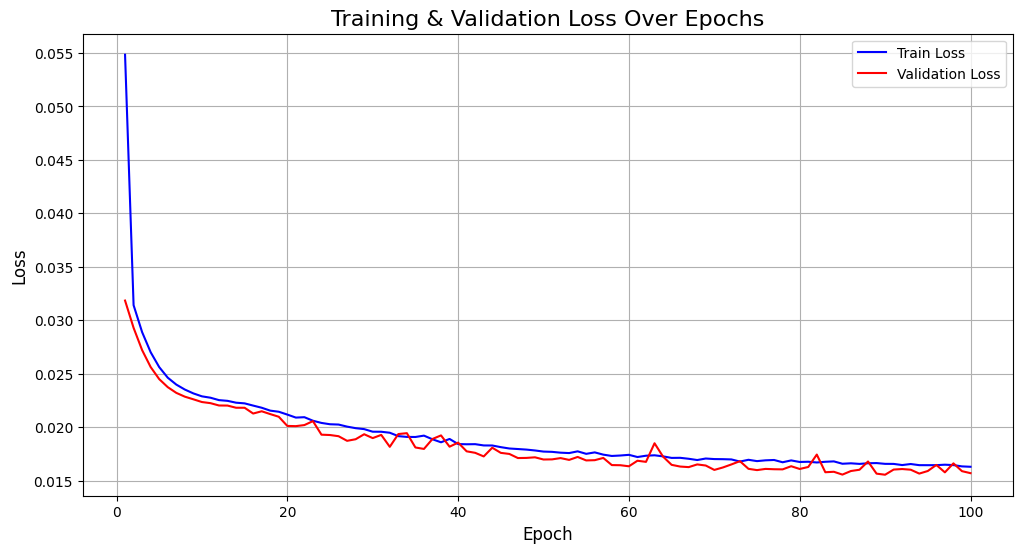

In [9]:
import matplotlib.pyplot as plt

# 그래프 크기 설정
plt.figure(figsize=(12, 6))

# 훈련 손실과 검증 손실 그래프 그리기
plt.plot(range(1, NUM_EPOCHS + 1), train_loss_history, label='Train Loss', color='blue')
plt.plot(range(1, NUM_EPOCHS + 1), val_loss_history, label='Validation Loss', color='red')

# 그래프 제목 및 축 레이블 설정
plt.title('Training & Validation Loss Over Epochs', fontsize=16)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)

# 범례 표시
plt.legend()

# 그리드 표시
plt.grid(True)

# 그래프 보여주기
plt.show()

In [10]:
# 새로운 셀

import numpy as np
from skimage.metrics import peak_signal_noise_ratio, structural_similarity

# --- 설정 (★★★ 사용 전 꼭 수정해주세요 ★★★) ---
# 1. 평가에 사용할 테스트셋 폴더 경로
TEST_DIR = os.path.join(DATA_DIR, 'test')

# 2. 불러올 학습된 모델 가중치 파일의 경로
# 'trained_models' 폴더 안에 저장된 .pth 파일 중 가장 성능이 좋았던(best) 모델의 경로를 지정합니다.
MODEL_WEIGHTS_PATH = "pt/TBaodNetV3/best_model_epoch_90.pth" # XX 부분은 실제 파일 숫자로 변경
# --------------------------------------------------

# 모델 구조 로드 및 가중치 불러오기
evaluation_model = AODnet_MultiBranch_V3().to(DEVICE)
evaluation_model.load_state_dict(torch.load(MODEL_WEIGHTS_PATH, map_location=DEVICE))
evaluation_model.eval() # 모델을 반드시 평가 모드로 설정!

# 테스트 데이터 로더 준비
test_dataset = DehazeDataset(data_dir=TEST_DIR, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False, num_workers=0) # num_workers=0으로 설정

# 점수를 저장할 리스트 초기화
psnr_scores = []
ssim_scores = []

print(f"\n===== '{MODEL_WEIGHTS_PATH}' 모델 성능 평가 시작 =====")

# 평가 루프
with torch.no_grad(): # 기울기 계산 비활성화
    for hazy_images, clean_images in tqdm(test_loader, desc="Evaluating"):
        hazy_images = hazy_images.to(DEVICE)
        
        # 모델 추론
        outputs = evaluation_model(hazy_images)
        
        # GPU 텐서를 CPU의 Numpy 배열로 변환 (skimage 계산용)
        # (B, C, H, W) -> (B, H, W, C) 형태로 변경 및 0-255 범위의 정수형으로 변환
        outputs_np = outputs.cpu().permute(0, 2, 3, 1).numpy() * 255
        clean_images_np = clean_images.cpu().permute(0, 2, 3, 1).numpy() * 255
        
        outputs_np = outputs_np.astype(np.uint8)
        clean_images_np = clean_images_np.astype(np.uint8)
        
        # 배치 내의 각 이미지에 대해 점수 계산
        for i in range(clean_images_np.shape[0]):
            gt_image = clean_images_np[i]
            pred_image = outputs_np[i]
            
            # PSNR 계산
            psnr = peak_signal_noise_ratio(gt_image, pred_image, data_range=255)
            psnr_scores.append(psnr)
            
            # SSIM 계산
            # channel_axis=-1 은 컬러 이미지(RGB)의 채널 축을 지정해줍니다.
            ssim = structural_similarity(gt_image, pred_image, channel_axis=-1, data_range=255)
            ssim_scores.append(ssim)

# 평균 점수 계산
avg_psnr = np.mean(psnr_scores)
avg_ssim = np.mean(ssim_scores)

print("\n===== 평가 완료 =====")
print(f"테스트 데이터셋 평균 PSNR: {avg_psnr:.4f} dB")
print(f"테스트 데이터셋 평균 SSIM: {avg_ssim:.4f}")

[Model] V3 Multi-Branch AODNet (Residual) 초기화 중...
[Model] V3 Multi-Branch AODNet 초기화 완료


===== 'pt/TBaodNetV3/best_model_epoch_90.pth' 모델 성능 평가 시작 =====


Evaluating: 100%|██████████| 127/127 [00:26<00:00,  4.74it/s]


===== 평가 완료 =====
테스트 데이터셋 평균 PSNR: 19.1660 dB
테스트 데이터셋 평균 SSIM: 0.7139


[Model] V3 Multi-Branch AODNet (Residual) 초기화 중...
[Model] V3 Multi-Branch AODNet 초기화 완료

이미지 복원을 시작합니다...
'dataset_split/test/input/51_rain.png' 복원 및 정답 이미지 로드 완료.
'dataset_split/test/input/im_0048_s95_a06.png' 복원 및 정답 이미지 로드 완료.
'dataset_split/test/input/NYU2_1331.jpg' 복원 및 정답 이미지 로드 완료.


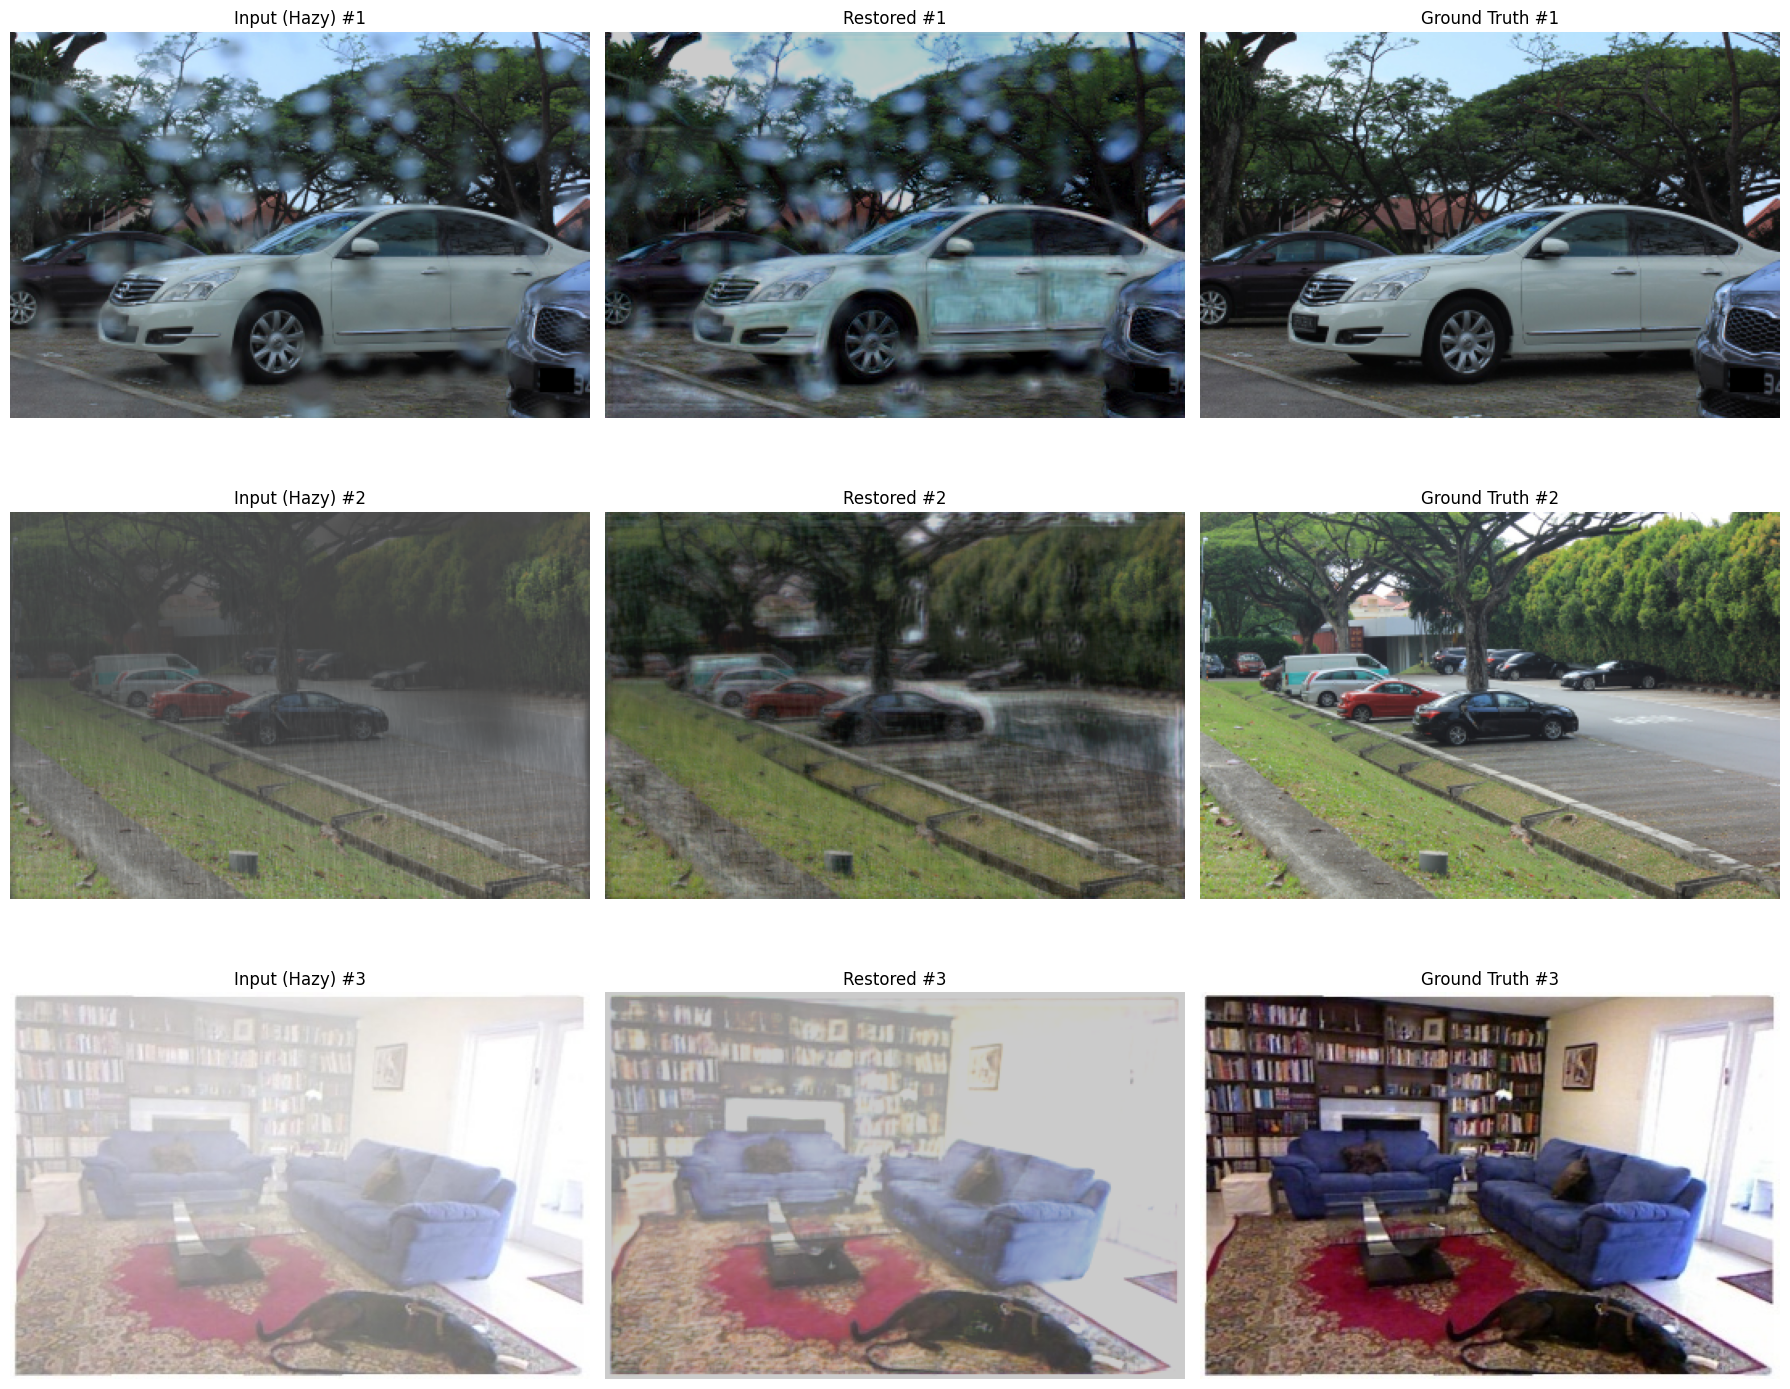


이미지 복원 및 비교 완료!


In [11]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import torch
from torchvision import transforms
import os

# --- 설정 (★★★ 사용 전 꼭 수정해주세요 ★★★) ---
# 1. 불러올 학습된 모델 가중치 파일의 경로
MODEL_WEIGHTS_PATH = "pt/TBaodNetV3/best_model_epoch_90.pth"

# 2. 복원할 안개 이미지(input) 파일 경로들을 리스트 형태로 지정
HAZY_IMAGE_PATHS = [
    "dataset_split/test/input/51_rain.png",
    "dataset_split/test/input/im_0048_s95_a06.png",
    "dataset_split/test/input/NYU2_1331.jpg"
]

# 3. 정답 이미지(gt)가 들어있는 폴더 경로
GT_BASE_DIR = "dataset_split/test/gt"

# 4. 모델 학습 시 사용했던 이미지 해상도
TARGET_IMAGE_SIZE = (240, 360)
# ----------------------------------------------------------------------

# 모델 구조 로드 및 가중치 불러오기
evaluation_model = AODnet_MultiBranch_V3().to(DEVICE) # DEVICE는 이전 셀에서 정의됨
evaluation_model.load_state_dict(torch.load(MODEL_WEIGHTS_PATH, map_location=DEVICE))
evaluation_model.eval()

# 이미지 전처리 transform 정의
transform = transforms.Compose([
    transforms.Resize(TARGET_IMAGE_SIZE),
    transforms.ToTensor()
])

# 결과를 저장할 리스트 생성
hazy_images_pil = []
restored_images_pil = []
clean_images_pil = []

print("이미지 복원을 시작합니다...")

for hazy_path in HAZY_IMAGE_PATHS:
    try:
        filename = os.path.basename(hazy_path)
        
        # ★★★ 수정된 부분 ★★★
        # os.path.join으로 생성된 경로를 os.path.normpath로 정규화
        clean_path_raw = os.path.join(GT_BASE_DIR, filename)
        clean_path = os.path.normpath(clean_path_raw)
        
        if not os.path.exists(clean_path):
            print(f"경고: 짝이 되는 정답 이미지 '{clean_path}'를 찾을 수 없습니다. 건너뜁니다.")
            continue

        hazy_image = Image.open(hazy_path).convert('RGB')
        clean_image = Image.open(clean_path).convert('RGB')
        
        hazy_tensor = transform(hazy_image).unsqueeze(0).to(DEVICE)

        with torch.no_grad():
            restored_tensor = evaluation_model(hazy_tensor)

        restored_image = transforms.ToPILImage()(restored_tensor.squeeze(0).cpu())

        hazy_images_pil.append(hazy_image)
        restored_images_pil.append(restored_image)
        clean_images_pil.append(clean_image)
        print(f"'{hazy_path}' 복원 및 정답 이미지 로드 완료.")

    except FileNotFoundError:
        print(f"오류: '{hazy_path}' 파일을 찾을 수 없습니다. 경로를 다시 확인해주세요.")
    except Exception as e:
        print(f"'{hazy_path}' 처리 중 오류 발생: {e}")

# --- 시각화 부분 ---
if hazy_images_pil:
    num_images = len(hazy_images_pil)
    # 3개의 행(이미지 쌍), 3개의 열(Input, Restored, GT)
    plt.figure(figsize=(18, 5 * num_images)) 

    for i in range(num_images):
        # --- i번째 이미지 쌍 ---
        
        # 1열: 입력(Hazy) 이미지
        plt.subplot(num_images, 3, i * 3 + 1)
        plt.imshow(hazy_images_pil[i])
        plt.title(f'Input (Hazy) #{i+1}')
        plt.axis('off')

        # 2열: 복원된 이미지
        plt.subplot(num_images, 3, i * 3 + 2)
        plt.imshow(restored_images_pil[i])
        plt.title(f'Restored #{i+1}')
        plt.axis('off')
        
        # 3열: 정답(GT) 이미지
        plt.subplot(num_images, 3, i * 3 + 3)
        plt.imshow(clean_images_pil[i])
        plt.title(f'Ground Truth #{i+1}')
        plt.axis('off')

    plt.tight_layout()
    plt.show()
    print("\n이미지 복원 및 비교 완료!")

In [ ]:
# 객체 탐지 추가 yolo 사용